<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/handson_ml_03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handson-ML Chapter 3 - Classification



## Setup

In [0]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import describe

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [0]:
rnd_seed = 43

MNIST

In [0]:
def sort_by_target(mnist):
  reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
  reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
  mnist.data[:60000] = mnist.data[reorder_train]
  mnist.target[:60000] = mnist.target[reorder_train]
  mnist.data[60000:] = mnist.data[reorder_test + 60000]
  mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [0]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
print(mnist['data'], mnist['target'])
print(f'mnist shape: {mnist.data.shape}')
X, y = mnist['data'], mnist['target']

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [0 0 0 ... 9 9 9]
mnist shape: (70000, 784)


In [0]:
describe(y)

DescribeResult(nobs=array(70000), minmax=(masked_array(data=0,
             mask=False,
       fill_value=999999,
            dtype=int8), masked_array(data=9,
             mask=False,
       fill_value=999999,
            dtype=int8)), mean=4.452428571428571, variance=8.353108387755103, skewness=masked_array(data=0.02789372,
             mask=False,
       fill_value=1e+20), kurtosis=-1.2554316702756645)

In [0]:
def plot_digit(data):
  image = data.reshape(28, 28)
  plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
  plt.axis('off');

In [0]:
def plot_digits(instances, images_per_row=10, **options):
  size = 28
  images_per_row = min(len(instances), images_per_row)
  images = [instance.reshape(size, size) for instance in instances]
  n_rows = (len(instances) - 1) // images_per_row + 1
  row_images = []
  n_empty = n_rows * images_per_row - len(instances)
  images.append(np.zeros((size, size * n_empty)))
  for row in range(n_rows):
      rimages = images[row * images_per_row : (row + 1) * images_per_row]
      row_images.append(np.concatenate(rimages, axis=1))
  image = np.concatenate(row_images, axis=0)
  plt.imshow(image, cmap = mpl.cm.binary, **options)
  plt.axis('off');

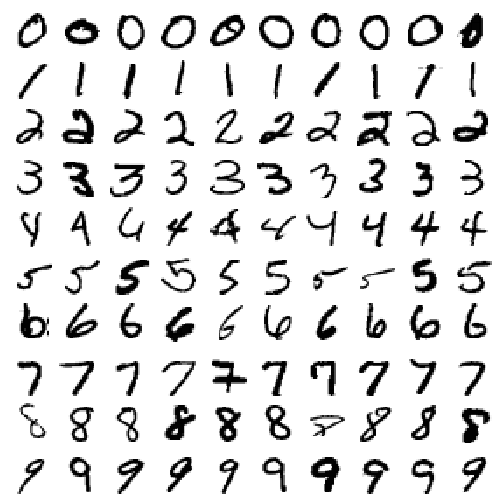

In [0]:
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=rnd_seed, 
                                                    stratify=y,
                                                    shuffle=True)

## Binary Classifier

In [0]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=rnd_seed)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=43, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

array([False])

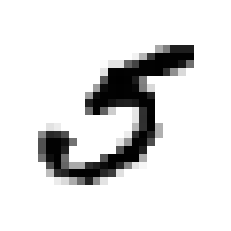

In [0]:
some_five = X[36000]
plot_digit(some_five)
sgd_clf.predict([some_five])

In [0]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy').mean()

0.9589590132970707

In [0]:
skfolds = StratifiedKFold(n_splits=3, random_state=rnd_seed)
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = (y_train_5[train_index])
  X_test_fold = X_train[test_index]
  y_test_fold = (y_train_5[test_index])
  
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9673074568384964
0.9560399191820241
0.9535296638706913


In [0]:
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [0]:
never_5_clf = Never5Classifier()
cv_score = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, 
                           scoring='accuracy').mean()
print('--- Never 5 | Baseline ---')
print(f'Cross validation score: {cv_score}')
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
print(f'Confusion matrix: {conf_matrix}')
print(f'Precision: {precision_score(y_train_5, y_train_pred)}')
print('--- Precision: When it predicts yes, how often it is correct?')
print(f'Precision 2: {conf_matrix[1,1] / (conf_matrix[0,1] + conf_matrix[1,1])}')

--- Never 5 | Baseline ---
Cross validation score: 0.909816380182009
Confusion matrix: [[43398  1183]
 [  828  3591]]
Precision: 0.7521994134897361
--- Precision: When it predicts yes, how often it is correct?
Precision 2: 0.7521994134897361


In [0]:
print('--- Recall: When it\'s actually yes, how often does it predict yes?')
print(f'recall: {recall_score(y_train_5, y_train_pred)}')


--- Recall: When it's actually yes, how often does it predict yes?
recall: 0.8126272912423625


In [0]:
print(f'f1_score: {f1_score(y_train_5, y_train_pred)}')

f1_score: 0.7812466006744262


In [0]:
y_scores = sgd_clf.decision_function([some_five])
y_scores

array([-1151.92497767])

In [0]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method='decision_function')
y_scores.shape

(49000,)

In [0]:
if y_scores.ndim == 2:
  y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

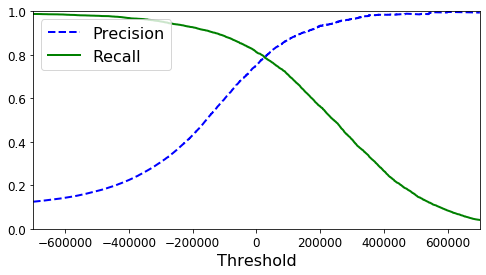

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.xlabel('Threshold', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000]);

In [0]:
(y_train_pred == (y_scores > 0)).all()

True

## The ROC curve

In [0]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

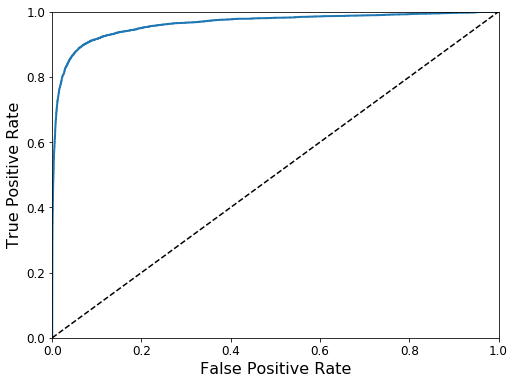

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate', fontsize=16)
  plt.ylabel('True Positive Rate', fontsize=16);

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

In [0]:
roc_auc_score(y_train_5, y_scores)

0.963016838503007

In [0]:
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method='predict_proba')

In [0]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

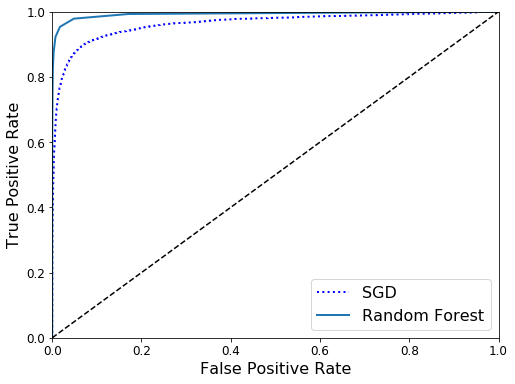

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right', fontsize=16);

In [0]:
roc_auc_score(y_train_5, y_scores_forest)

0.9924644310397037

In [0]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred)

0.7521994134897361

In [0]:
recall_score(y_train_5, y_train_pred_forest)

0.8225842950893867

## Multiclass classification

In [0]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_five])

array([5], dtype=int8)

In [0]:
some_digits_scores = sgd_clf.decision_function([some_five])
some_digits_scores

array([[-473417.08074212, -557106.27228772, -404845.20866491,
        -270128.59085354, -419415.43495394,  -65326.07819784,
        -822936.1014112 , -244152.90736363, -958942.80679485,
        -858584.18990106]])

In [0]:
np.argmax(some_digits_scores)

5

In [0]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [0]:
sgd_clf.classes_[5]

5

In [0]:
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_five])

array([5], dtype=int8)

In [0]:
len(ovo_clf.estimators_)

45

In [0]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_five])

array([5], dtype=int8)

In [0]:
forest_clf.predict_proba([some_five])

array([[0. , 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0.1]])

In [0]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.86182197, 0.87883426, 0.8777322 ])

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91098323, 0.90712055, 0.91067165])

## Error Analysis

In [0]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[4686,    2,   18,    7,    8,   38,   35,    4,   29,    5],
       [   2, 5307,   38,   23,    5,   31,    5,   10,   86,    7],
       [  37,   29, 4365,   93,   72,   24,   80,   47,  136,   10],
       [  35,   24,  120, 4379,    3,  177,   24,   42,  109,   86],
       [  13,   21,   35,    9, 4371,    9,   51,   28,   66,  174],
       [  51,   34,   22,  160,   69, 3773,   87,   26,  125,   72],
       [  28,   20,   33,    2,   41,   88, 4559,    4,   37,    1],
       [  24,   19,   59,   21,   40,   11,    6, 4732,   15,  178],
       [  38,  119,   58,  122,   16,  128,   53,   24, 4091,  128],
       [  35,   25,   21,   75,  138,   29,    3,  172,   66, 4307]])

In [0]:
def plot_confusion_matrix(matrix):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  cax = ax.matshow(matrix)
  fit.colorbar(cax)

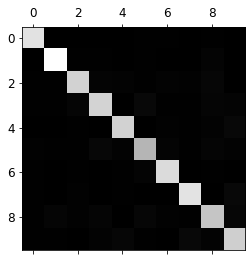

In [0]:
plt.matshow(conf_mx, cmap=plt.cm.gray);

In [0]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

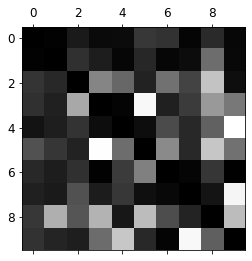

In [0]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray);

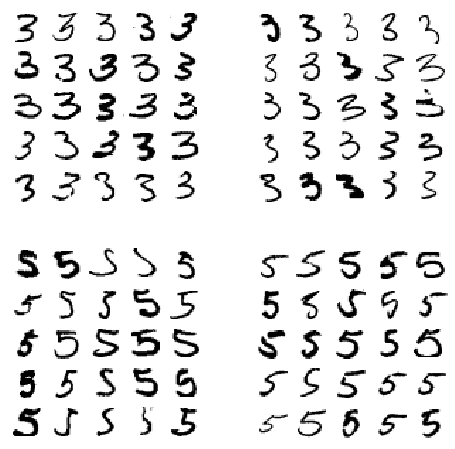

In [0]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5);

## Multilabel Classification

In [0]:
y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
knn_clf.predict([some_five])

array([[False,  True]])

In [0]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average='macro')